# Creating 2D Tree Representations for Individual Cell Clone Lineages:

The aim of this notebook is to illustrate how we visualise the lineage data in a comprehensive, 2D representations. We source the data from our segmented, classified and tracked time-lapse microscopy movies. For more details about the `CellTracking` pipeline, visit our [GitHub repository](https://github.com/quantumjot/CellTracking "quantumjot/CellTracking").

In [7]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

from Tree_DataIO import Extract_Tree_Branches_from_HDF
from Tree_Plotter import Lineage_Tree, LineageTreePlotter_Figure, LineageTreePlotter_Grid


From our example movie data, have a look at a few randomly selected trees: for the ease of your analysis, the ID labels of their respective founder cells were shortlisted for you below in the `tree_IDs` tuple:

In [8]:
bt_file = "../example_segment_classif_tracked_movie.hdf5"


In [9]:
tree_IDs = (2, 6, 11, 12, 13, 14, 15, 16, 17, 18, 19, 22, 27, 30, 31, 33, 36, 38, 42, 52, 56, 58, 60, 63)
print (f"Lineage Trees: {len(tree_IDs)}")


Lineage Trees: 24


### Plot the individual trees, one at a time:

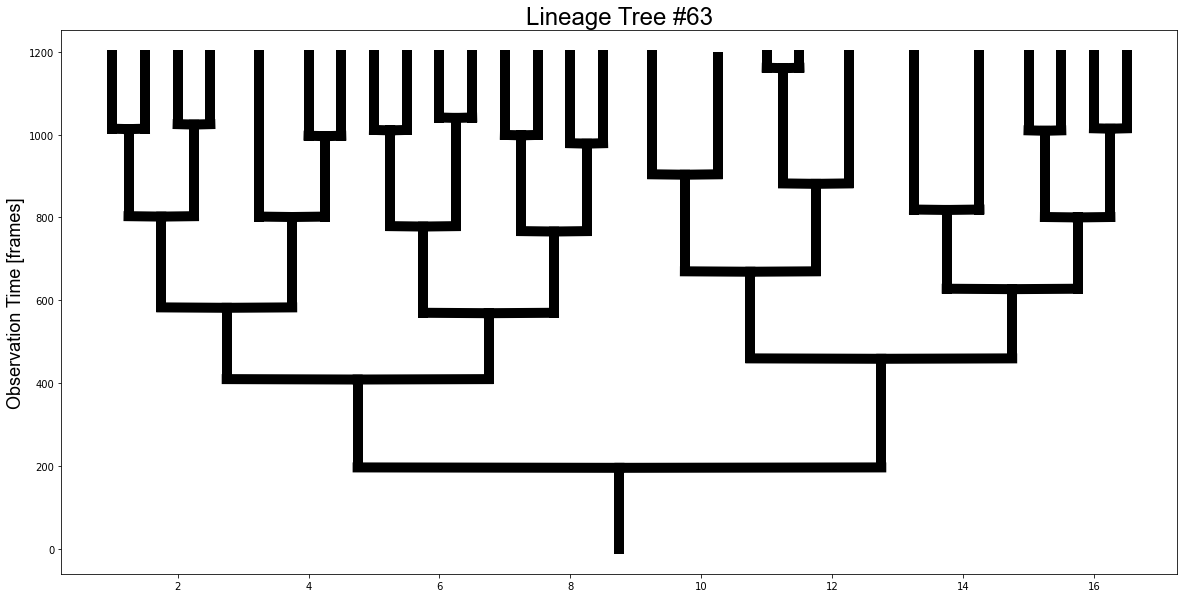

In [4]:
for enum, tree_ID in enumerate(tree_IDs[::-1]):
    
    fig, (axs) = plt.subplots(figsize=(20, 10), nrows=1, ncols=1)
    
    bt = Extract_Tree_Branches_from_HDF(tree_ID, hdf5_file=bt_file)
    tree_bt = Lineage_Tree(hdf5_file=bt_file, tree_root_ID=tree_ID)
    tree = tree_bt.create_tree()
    LineageTreePlotter_Figure(axis_index=0, order=0).plot(tree=tree, color="cyan", linewidth=10.0, markersize=0, alpha=1.0, labels=False)
    
    plt.title(f"Lineage Tree #{tree_ID}", fontname="Arial", fontsize=24)
    plt.ylabel("Observation Time [frames]", fontname="Arial", fontsize=18)
    plt.show()
    
    break
    

### Define the Plotting tool class:

In [5]:
class LineageTreePlotter_Grid(object):

    def __init__(self, axis_index, order):
        self.axis_index = axis_index
        self.order = order
        self.reset()

    def reset(self):
        self.y = 0  # reset the position iterator

    def plot(self, tree, color, linewidth, markersize, alpha, labels):

        queue, marked, y_pos = [], [], []

        # put the start vertex into the queue, and the marked list
        queue.append(tree)
        marked.append(tree)
        y_pos.append(0)

        # store the line coordinates that need to be plotted
        line_list = []
        text_list = []
        marker_list = []

        # now step through
        while len(queue) > 0:
            # pop the root from the tree
            node = queue.pop(0)
            y = y_pos.pop(0)

            # draw the root of the tree
            line_list.append(([y, y], [node.st, node.en]))
            marker_list.append((y, node.st, color, '.', linewidth, markersize, alpha))

            # TODO: Mark if this is an apoptotic tree!
            marker_list.append((y, node.en, color, 's', linewidth, markersize, alpha))
            text_list.append((y, node.en, str(node.ID), 'k'))

            if tree.ID == node.ID:
                text_list.append((y, node.st, str(node.ID), 'k'))

            for child in node.children:
                if child not in marked:

                    # mark the children
                    marked.append(child)
                    queue.append(child)

                    # calculate the depth modifier
                    depth_mod = 2. / (2. ** (node.depth - 1.))

                    if child == node.children[0]:
                        y_pos.append(y + depth_mod)
                    else:
                        y_pos.append(y - depth_mod)

                    # plot a linking line to the children
                    line_list.append(([y, y_pos[-1]], [node.en, child.st]))
                    marker_list.append((y, node.en, color, 'o', linewidth, markersize, alpha))
                    text_list.append((y_pos[-1], child.en - (child.en - child.st) / 2., str(child.ID), 'k'))

        # now that we have traversed the tree, calculate the span
        tree_span = []
        for line in line_list:
            tree_span.append(line[0][0])
            tree_span.append(line[0][1])

        min_x = min(tree_span)
        max_x = max(tree_span)

        # Plot the thing!
        y_offset = self.y - min_x + 1

        # lines
        for line in line_list:
            x, y = [xx + y_offset for xx in line[0]], line[1]
            axs[self.axis_index][self.order].plot(x, y, '-', color=color, linewidth=linewidth, markersize=markersize, alpha=alpha)

        # markers
        for marker in marker_list:
            axs[self.axis_index][self.order].plot(marker[0] + y_offset, marker[1], color=marker[2], marker=marker[3], linewidth=marker[4],
                     markersize=marker[5], alpha=marker[6])

        # labels
        if labels:
            for txt_label in text_list:
                axs[self.axis_index][self.order].text(txt_label[0] + y_offset - 0.1, txt_label[1] - 0.1, txt_label[2], fontsize=8,
                                     color=txt_label[3])

        # update the position for next round
        self.y = y_offset + max_x + 1


### Plot the grid of all shortlisted lineage trees in a single figure:

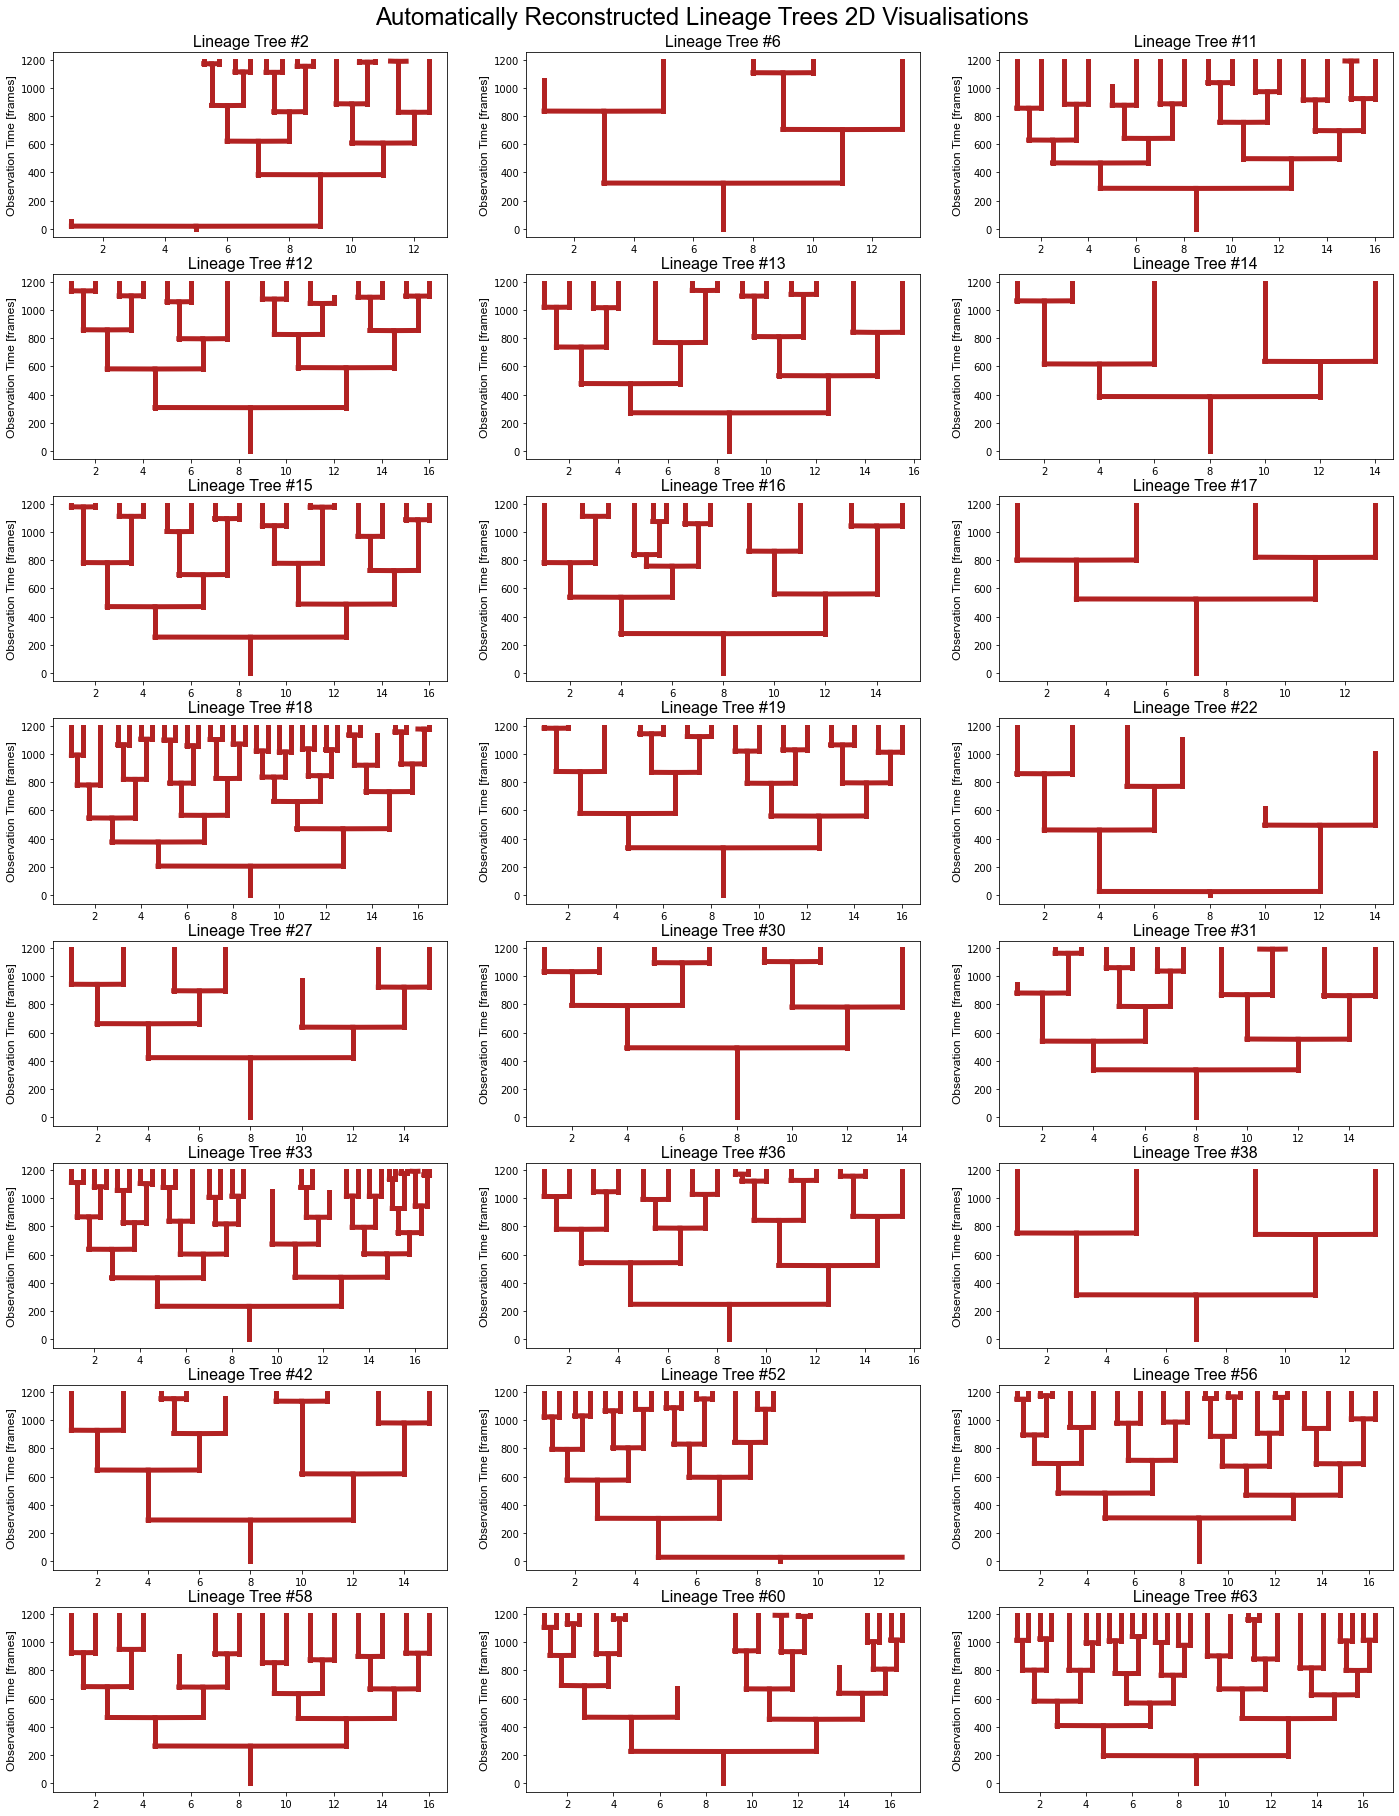

In [6]:
fig, axs = plt.subplots(figsize=(24, 32), nrows=8, ncols=3)
fig.suptitle(x=0.5, y=0.9, t=f"Automatically Reconstructed Lineage Trees 2D Visualisations", fontname="Arial", fontsize=24)

for enum, tree_ID in enumerate(tree_IDs):
    
    tree_bt = Lineage_Tree(hdf5_file=bt_file, tree_root_ID=tree_ID)
    tree = tree_bt.create_tree()
    LineageTreePlotter_Grid(axis_index=int(enum/3), order=enum%3).plot(tree=tree, color="firebrick", linewidth=5.0, markersize=0, alpha=1.0, labels=False)
    axs[int(enum/3)][enum%3].set_title(f"Lineage Tree #{tree_ID}", fontname="Arial", fontsize=16)
    axs[int(enum/3)][enum%3].set_ylabel("Observation Time [frames]", fontname="Arial", fontsize=12)
    
    #break 
    
plt.show()
    

### Done!